# This file is to generate the proximity matricies; Data Agnostic
- Helpful to just change a few lines of code where to import the data from. 

In [5]:
# Load up data

#& Imports
import sys
sys.path.insert(0, '/yunity/arusty/PF-GAP')
import os

#Import libraries, MDS from SKlearn, and all the custom files
import pandas as pd
from Pipeline.functions import *

#Functions
from QGAP.qgap import QGAP
from Redcomets.Redcomets import REDCOMETS
from RFGAP_Rocket.RFGAP_Rocket import RFGAP_Rocket
from RDST.rdst import RDST_GAP
from FreshPrince.FreshPrince import FreshPRINCE_GAP


#& Data Loading
time_series = pd.read_csv("/yunity/arusty/PF-GAP/data/ftse_100_close_prices.csv", index_col=0)
static =  None
labels = np.array(pd.read_csv("/yunity/arusty/PF-GAP/data/ftse_100_sectors_grouped.csv")).flatten()
data_dir = "../../data/ftse_100/grouped_results/"


In [6]:
time_series.shape, labels.shape, static.shape if static is not None else "No static data"

((100, 1007), (100,), 'No static data')

# Generating the proximities

In [7]:
print("Beggining QGAP...")
qgap = QGAP(matrix_type="dense", interval_depth = 8, quantile_divisor = 8)
quant_prox = data_to_proximities(qgap, time_series, labels, static)
np.save(os.path.join(data_dir, "quant_prox.npy"), quant_prox)
print("---- QGAP Finished")
print("---- OOB Score: ", qgap._estimator.oob_score_)

Beggining QGAP...
---- QGAP Finished
---- OOB Score:  0.45


In [8]:
print("Beggining Redcomets...")
if static is None:
    redcomets = REDCOMETS(variant = 3, perc_length = 0.7, n_trees = 100) 
else:
    redcomets = REDCOMETS(variant = 3, perc_length = 0.7, n_trees = 100, static_data=static)
redcomets_prox = data_to_proximities(redcomets, time_series, labels)
np.save(os.path.join(data_dir, "redcomets_prox.npy"), redcomets_prox)
print("---- Redcomets Finished")
print("---- OOB Score: ", redcomets.get_ensemble_oob_score())

Beggining Redcomets...
---- Redcomets Finished
---- OOB Score:  0.7773830357204403


In [9]:
print("Beggining RFGAP-Rockets...")
rf_rocket = RFGAP_Rocket(prediction_type = "classification", rocket = "Multi",
                         n_kernels=256) # Rocket Kwargs
rocket_prox = data_to_proximities(rf_rocket, time_series, labels, static)
np.save(os.path.join(data_dir, "rocket_prox.npy"), rocket_prox)
print("---- RFGAP-Rockets Finished")
print("---- OOB Score: ", rf_rocket.rf_gap.oob_score_)

Beggining RFGAP-Rockets...
---- RFGAP-Rockets Finished
---- OOB Score:  0.39


In [10]:
print("Beggining RDST...")
rdst = RDST_GAP(save_transformed_data = True, max_shapelets = 10000, 
                shapelet_lengths = None, alpha_similarity = 0.3)
rdst_prox = data_to_proximities(rdst, time_series, labels, static)

np.save(os.path.join(data_dir, "rdst_prox.npy"), rdst_prox)
print("---- RDST Finished")
print("---- OOB Score: ", rdst._estimator.oob_score_)


Beggining RDST...
---- RDST Finished
---- OOB Score:  0.4


In [11]:
print("Beggining Fresh Prince...")

# This requires a channel dimension
time_series_reshaped = np.expand_dims(time_series.values, axis=1)

fresh_prince = FreshPRINCE_GAP(default_fc_parameters="minimal", n_estimators=200)
fresh_prince_prox = data_to_proximities(fresh_prince, time_series_reshaped, labels, static)

np.save(os.path.join(data_dir, "fresh_prince_prox.npy"), fresh_prince_prox)
print("---- Fresh Prince Finished")

try:
    print("---- OOB Score: ", fresh_prince._estimator.oob_score_)
except:
    print("---- OOB Score: Not available for Fresh Prince")

Beggining Fresh Prince...
---- Fresh Prince Finished
---- OOB Score: Not available for Fresh Prince


In [12]:
print("Beggining PyF-GAP...")
sys.path.insert(0, '/yunity/arusty/PF-GAP/PFGAP')

#Check data shape to see if too large
if time_series.shape[1] > 500:
    print("---- PyF-GAP is not designed for large datasets, consider using a smaller dataset.")
    print("---- Truncating time series to 500 features.\n\n")
    time_series = time_series.iloc[:, -500:]
    
from PFGAP.PyPFGAP import PyPFGAP
pf = PyPFGAP()
pf_prox = data_to_proximities(pf, time_series, pd.Categorical(labels).codes.astype(str))

np.save(os.path.join(data_dir, "pf_prox.npy"), pf_prox)
print("\n\n---- PyF-GAP Finished")
print("---- OOB Score: Not available for PyF-GAP")

Beggining PyF-GAP...
---- PyF-GAP is not designed for large datasets, consider using a smaller dataset.
---- Truncating time series to 500 features.


reading file [train]:finished in 0:0:0.135
reading file [test]:finished in 0:0:0.025
Running on configurations...
Dataset: train, Training Data : 100x500 , Testing Data: 100x500, Train #Classes: 6, Test #Classes: 6
Repeats: 1 , Trees: 18 , Candidates per Split(r): 5
Output Dir: output, Export: 1, Verbosity: 1
Select DM per node: true , Shuffle Data: false, JVM WarmUp: false
----------------------------------------------------------------------------------------------------

-----------------Repetition No: 1 (train)   -----------------
Using: 4 MB, Free: 73 MB, Allocated Pool: 77 MB, Max Available: 1024 MB
core.ProximityForestResult@5e9f23b4
0.1.2.3.4.5.6.7.8.9.10.11.12.13.14.15.16.17.
Using: 478 MB, Free: 146 MB, Allocated Pool: 624 MB, Max Available: 1024 MB
*
Computing Forest Proximities...
Done Computing Forest Proximities. Computatio

# Getting test data and Validation Results
- Now that we have our proximities, lets get some numbers on the board! Woot!

In [13]:
time_series.to_numpy()

array([[-0.00141741, -0.02767923,  0.01386866, ...,  0.00231663,
        -0.00308173,  0.0061824 ],
       [ 0.02416574, -0.00084269, -0.01743042, ...,  0.        ,
        -0.00283629, -0.01137748],
       [-0.00470588, -0.03841596, -0.01413649, ...,  0.00782125,
        -0.00554327, -0.0016722 ],
       ...,
       [-0.00456482,  0.04341175,  0.        , ...,  0.00453854,
        -0.003012  , -0.00553882],
       [-0.0028027 , -0.01236648, -0.01309056, ..., -0.01111766,
        -0.00295852, -0.00059349],
       [ 0.0024326 , -0.00606625,  0.00335674, ..., -0.00934582,
        -0.00221969,  0.00472749]])

In [14]:
# Begin the Train test split stuff

#& Imports
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score
from sklearn.model_selection import train_test_split

#// Split the data into train and test sets
#// if static is not None:
#//     X_train, X_test, y_train, y_test, static_train, static_test = train_test_split(
#//                                                                 time_series, labels, static, 
#//                                                                 test_size=0.2, random_state=42
#//                                                                 )
#// else:
#//     X_train, X_test, y_train, y_test = train_test_split(
#//                                                         time_series, labels, 
#//                                                         test_size=0.2, random_state=42
#//                                                         )



def get_cross_validation_results(get_predictions_method):
    # Set up cross-validation
    skf = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)

    results = []

    for fold, (train_idx, test_idx) in enumerate(skf.split(time_series, labels)):
        print(f"Fold {fold + 1}/{skf.n_splits}: {len(train_idx)} train samples, {len(test_idx)} test samples.", end = " ->")
        # Split data
        X_train, X_test = time_series.to_numpy()[train_idx], time_series.to_numpy()[test_idx]
        y_train, y_test = labels[train_idx], labels[test_idx]
    
        if static is not None:
            y_pred, prox_train, prox_test = get_predictions_method(X_train, y_train, X_test, static[train_idx], static[test_idx])
        else:
            y_pred, prox_train, prox_test = get_predictions_method(X_train, y_train, X_test, None, None)
        
        # RF metrics
        rf_f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
        rf_recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
        rf_precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
        rf_acc = accuracy_score(y_test, y_pred)
        print(f" RF Accuracy: {rf_acc:.4f}")

        # KNN metrics
        if prox_train is None or prox_test is None:
            acc = None
            f1 = None
            precision = None
            recall = None
        else:
            knn = KNeighborsClassifier(n_neighbors=4, metric='precomputed')
            knn.fit(1 - prox_train, y_train)
            y_pred_knn = knn.predict(1 - prox_test)

            acc = accuracy_score(y_test, y_pred_knn)
            f1 = f1_score(y_test, y_pred_knn, average='weighted', zero_division=0)
            precision = precision_score(y_test, y_pred_knn, average='weighted', zero_division=0)
            recall = recall_score(y_test, y_pred_knn, average='weighted', zero_division=0)
            
        results.append({
            'fold': fold,
            'train_idx': train_idx,
            'test_idx': test_idx,
            'rf_f1': rf_f1,
            'rf_recall': rf_recall,
            'rf_precision': rf_precision,
            'rf_accuracy': rf_acc,
            'knn_accuracy': acc,
            'knn_f1': f1,
            'knn_precision': precision,
            'knn_recall': recall
        })

    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    
    return results_df._append({
        'fold': 'Average',
        'rf_f1': results_df['rf_f1'].mean(),
        'rf_recall': results_df['rf_recall'].mean(),
        'rf_precision': results_df['rf_precision'].mean(),
        'rf_accuracy': results_df['rf_accuracy'].mean(),
        'knn_accuracy': results_df['knn_accuracy'].mean(),
        'knn_f1': results_df['knn_f1'].mean(),
        'knn_precision': results_df['knn_precision'].mean(),
        'knn_recall': results_df['knn_recall'].mean()
    }, ignore_index=True)

import matplotlib.pyplot as plt

def plot_cv_results(results_df):
    """
    Plots cross-validation metrics for each fold, ignoring the average row.
    Args:
        results_df (pd.DataFrame): DataFrame returned by get_cross_validation_results
    """
    # Exclude the average row
    plot_df = results_df[results_df['fold'] != 'Average']

    metrics = [
        ("rf_accuracy", "RF Accuracy"),
        ("rf_f1", "RF F1"),
        #("rf_precision", "RF Precision"),
        #("rf_recall", "RF Recall"),
        ("knn_accuracy", "KNN Accuracy"),
        ("knn_f1", "KNN F1"),
        #("knn_precision", "KNN Precision"),
        #("knn_recall", "KNN Recall"),
    ]
    plt.figure(figsize=(12, 6))
    for metric, label in metrics:
        if metric in plot_df.columns:
            plt.plot(plot_df["fold"], plot_df[metric], marker='o', label=label)
    plt.xlabel("Fold")
    plt.ylabel("Score")
    plt.ylim(0, 1)
    plt.title("Cross-Validation Metrics by Fold")
    plt.legend()
    plt.grid(True)
    plt.show()

#& Models Here

def get_rocket_pred(X_train, y_train, X_test, static_train, static_test):
    rocket = RFGAP_Rocket(prediction_type = "classification", rocket = "Multi",
                         n_kernels=256, prox_method = "rfgap")
    
    rocket.fit(X_train, y_train, static_train, weights = None)
    return rocket.predict(X_test, static_test), rocket.get_proximities().toarray(), rocket.get_test_proximities(X_test, static_test).toarray()

def get_rdst_pred(X_train, y_train, X_test, static_train, static_test):
    rdst = RDST_GAP(save_transformed_data = True, prox_method = "rfgap",
                    max_shapelets = 10000, shapelet_lengths = None,
                    alpha_similarity = 0.3)
    rdst.fit(X_train, y_train, static = static_train)
    return rdst.predict(X_test, static = static_test), rdst.get_proximities().toarray(), rdst.extend_prox(X_test, static_test).toarray()

def get_qgap_pred(X_train, y_train, X_test, static_train, static_test):
    qgap = QGAP(matrix_type="dense", prox_method = "rfgap",
                interval_depth = 8, quantile_divisor = 8)
    qgap.fit(X_train, y_train, static = static_train)
    return qgap.predict(X_test, static = static_test), qgap.get_proximities(), np.array(qgap.prox_extend(X_test, static_test))

def get_redcomets_pred(X_train, y_train, X_test, static_train, static_test):
    rc = REDCOMETS(static = static_train, variant=3, prox_method = "rfgap",
                   perc_length=0.7, n_trees = 100)
    rc.fit(X_train, y_train)
    return rc.predict(X_test, static = static_test), None, None

def get_fresh_pred(X_train, y_train, X_test, static_train, static_test):
    fp = FreshPRINCE_GAP(prox_method = "rfgap", default_fc_parameters="minimal", n_estimators=200)
    fp.fit(X_train, y_train, static = static_train)
    return fp.predict(X_test, static = static_test), np.array(fp.get_proximities().todense()), np.array(fp.get_extend(X_test, static_test).todense())

Beggining Rocket Cross Validation Tests...
Fold 1/6: 83 train samples, 17 test samples. -> RF Accuracy: 0.4118
Fold 2/6: 83 train samples, 17 test samples. -> RF Accuracy: 0.5882
Fold 3/6: 83 train samples, 17 test samples. -> RF Accuracy: 0.4118
Fold 4/6: 83 train samples, 17 test samples. -> RF Accuracy: 0.3529
Fold 5/6: 84 train samples, 16 test samples. -> RF Accuracy: 0.3750
Fold 6/6: 84 train samples, 16 test samples. -> RF Accuracy: 0.2500
---- Rocket Cross Validation Finished


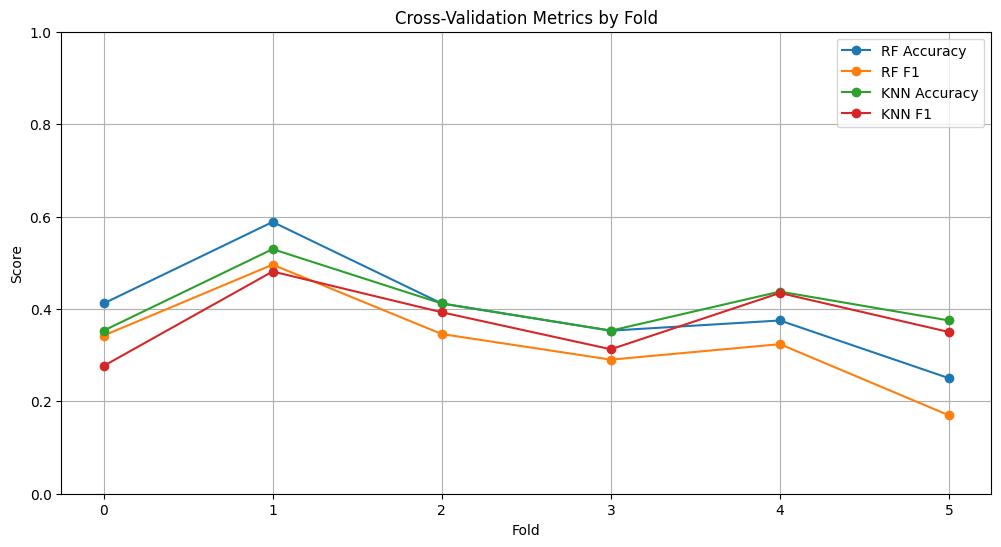

In [15]:
print("Beggining Rocket Cross Validation Tests...")
rocket_fold = get_cross_validation_results(get_rocket_pred)
rocket_fold.to_csv(os.path.join(data_dir, "rocket_scores.csv"), index=False)
print("---- Rocket Cross Validation Finished")
plot_cv_results(rocket_fold) 

In [ ]:
print("Beggining RDST Cross Validation Tests...")
rdst_fold = get_cross_validation_results(get_rdst_pred)
rdst_fold.to_csv(os.path.join(data_dir, "rdst_scores.csv"), index=False)
print("---- RDST Cross Validation Finished")
plot_cv_results(rdst_fold)

Beggining RDST Cross Validation Tests...
Fold 1/6: 83 train samples, 17 test samples. -> RF Accuracy: 0.6471
Fold 2/6: 83 train samples, 17 test samples. -> RF Accuracy: 0.5294
Fold 3/6: 83 train samples, 17 test samples. -> RF Accuracy: 0.5294
Fold 4/6: 83 train samples, 17 test samples. ->

Beggining QGAP Cross Validation Tests...
Fold 1/6: 83 train samples, 17 test samples. ->

/yunity/arusty/PF-GAP/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(


 RF Accuracy: 0.2353
Fold 2/6: 83 train samples, 17 test samples. -> RF Accuracy: 0.2941
Fold 3/6: 83 train samples, 17 test samples. -> RF Accuracy: 0.2941
Fold 4/6: 83 train samples, 17 test samples. -> RF Accuracy: 0.2941
Fold 5/6: 84 train samples, 16 test samples. -> RF Accuracy: 0.1250
Fold 6/6: 84 train samples, 16 test samples. -> RF Accuracy: 0.3750
---- QGAP Cross Validation Finished


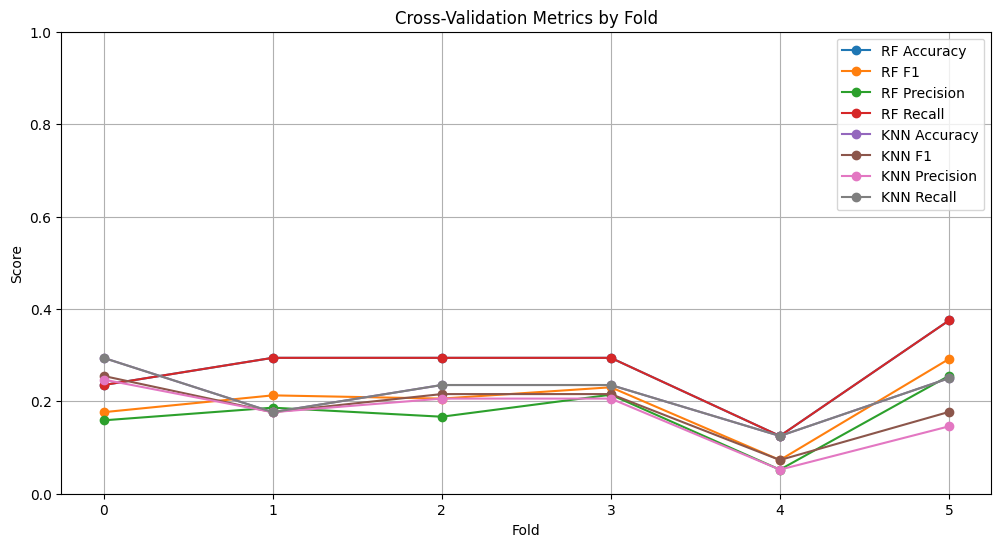

In [ ]:
print("Beggining QGAP Cross Validation Tests...")
qgap_fold = get_cross_validation_results(get_qgap_pred)
qgap_fold.to_csv(os.path.join(data_dir, "qgap_scores.csv"), index=False)
print("---- QGAP Cross Validation Finished")
plot_cv_results(qgap_fold)

Beggining Redcomets Cross Validation Tests...
Fold 1/6: 83 train samples, 17 test samples. ->

/yunity/arusty/PF-GAP/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(


 RF Accuracy: 0.4706
Fold 2/6: 83 train samples, 17 test samples. -> RF Accuracy: 0.4118
Fold 3/6: 83 train samples, 17 test samples. -> RF Accuracy: 0.3529
Fold 4/6: 83 train samples, 17 test samples. -> RF Accuracy: 0.4118
Fold 5/6: 84 train samples, 16 test samples. -> RF Accuracy: 0.1875
Fold 6/6: 84 train samples, 16 test samples. -> RF Accuracy: 0.3125
---- Redcomets Cross Validation Finished


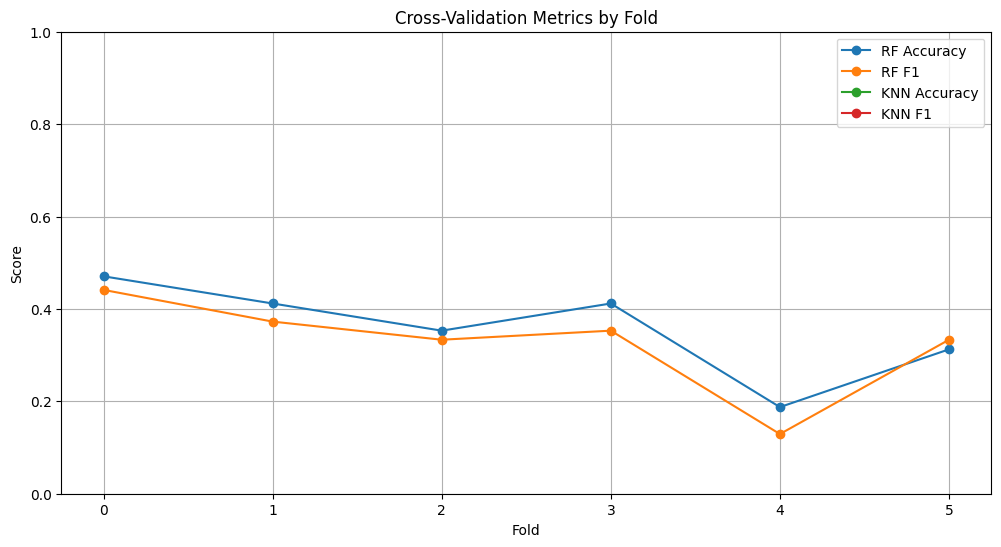

In [ ]:
print("Beggining Redcomets Cross Validation Tests...")
redcomets_fold = get_cross_validation_results(get_redcomets_pred)
redcomets_fold.to_csv(os.path.join(data_dir, "redcomets_scores.csv"), index=False)
print("---- Redcomets Cross Validation Finished")
plot_cv_results(redcomets_fold)

Beggingin Fresh Prince Cross Validation Tests...
Fold 1/6: 83 train samples, 17 test samples. ->

/yunity/arusty/PF-GAP/.venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(


 RF Accuracy: 0.5294
Fold 2/6: 83 train samples, 17 test samples. -> RF Accuracy: 0.4706
Fold 3/6: 83 train samples, 17 test samples. -> RF Accuracy: 0.3529
Fold 4/6: 83 train samples, 17 test samples. -> RF Accuracy: 0.3529
Fold 5/6: 84 train samples, 16 test samples. -> RF Accuracy: 0.1875
Fold 6/6: 84 train samples, 16 test samples. -> RF Accuracy: 0.3125
---- Fresh Prince Cross Validation Finished


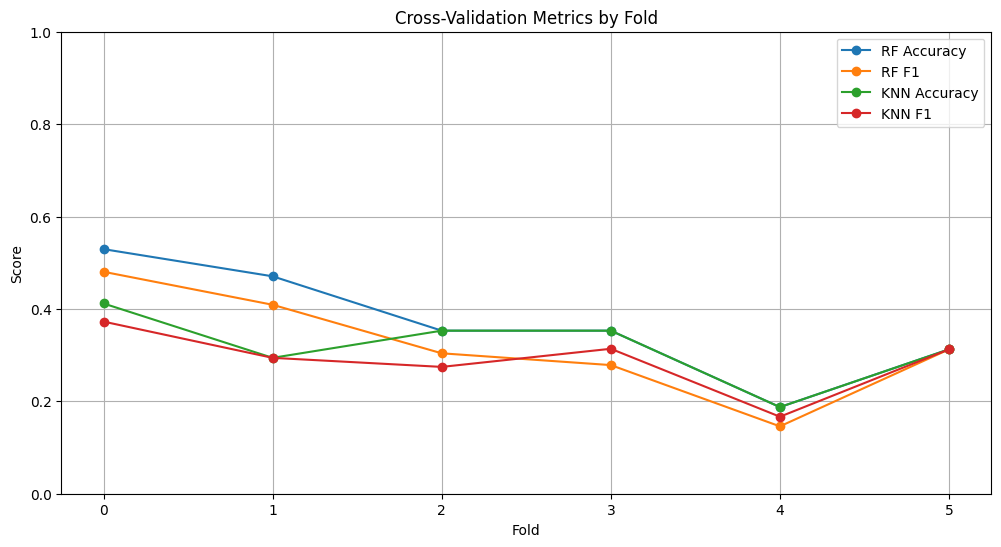

In [ ]:
print("Beggingin Fresh Prince Cross Validation Tests...")
fresh_fold = get_cross_validation_results(get_fresh_pred)
fresh_fold.to_csv(os.path.join(data_dir, "fresh_scores.csv"), index=False)
print("---- Fresh Prince Cross Validation Finished")
plot_cv_results(fresh_fold)